In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import numpy as np
import matplotlib.pyplot as plt
import pickle
import torch

from libs.TrafficGenerator import DatasetConvertor 
from libs.TrafficPredictor.ContextAssisted import PreparingDataset as PreparingDatasetCA
from libs.TrafficPredictor.ContextAssisted import trainModelByDefaultSetting as trainModelCA
from libs.TrafficPredictor.ContextAssisted import evaluateModel as evaluateModelCA
from libs.TrafficPredictor.ContextAssisted import createModel as createModelCA
from libs.TrafficPredictor.ContextPerfect import PreparingDataset as PreparingDatasetPerfect
from libs.TrafficPredictor.ContextPerfect import trainModelByDefaultSetting as trainModelPerfect
from libs.TrafficPredictor.ContextPerfect import evaluateModel as evaluateModelPerfect
from libs.TrafficPredictor.ContextPerfect import createModel as createModelPerfect
from libs.TrafficPredictor.ContextFree import PreparingDataset as PreparingDatasetCF
from libs.TrafficPredictor.ContextFree import trainModelByDefaultSetting as trainModelCF
from libs.TrafficPredictor.ContextFree import evaluateModel as evaluateModelCF
from libs.TrafficPredictor.ContextFree import createModel as createModelCF
from libs import encode_float_filename, decode_float_filename

In [2]:
stringFile = encode_float_filename(0.5)
floatFile = decode_float_filename(stringFile)
print(stringFile)
print(floatFile)

5_00e-01.txt
0.5


In [3]:
#dbParams = 0.01
#direction = "forward"
dbParams = 0.2
direction = "backward"
mode = "fixed"
#mode = "adaptive"
alpha = 0.5

rawDatasetFolder = "Dataset"
datasetConverter = DatasetConvertor(rawDatasetFolder)
datasetConverter.processDataset(dbParameter=dbParams, alpha=alpha, mode=mode, direction=direction)
#thumbUnit = datasetConverter.getDataUnit('thumb_fr')
thumbUnit = datasetConverter.getDataUnit('thumb_bk')

========== thumb ============
Backward: Compression rate:0.2032248455322052
========== index ============
Backward: Compression rate:0.18577454908856794
========== middle ============
Backward: Compression rate:0.19320245611000605


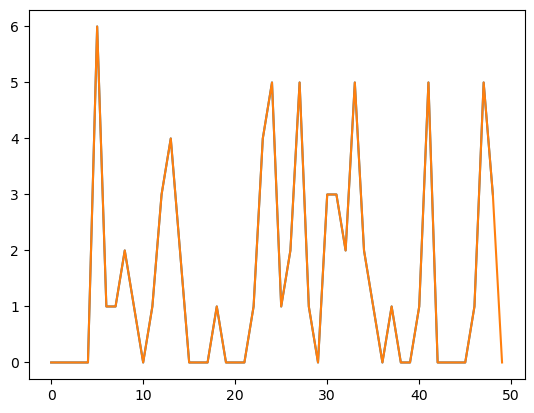

In [4]:
lenWindow = 10
paramsCA = {}
paramsCA['lenSource'] = lenWindow
paramsCA['lenTarget'] = lenWindow
paramsCA['trainRatio'] = 0.8
paramsCA['dataAugment'] = False
paramsCA['smoothFc'] = 2.5
paramsCA['smoothOrder'] = 3
trainDataCA, testDataCA = PreparingDatasetCA(thumbUnit, paramsCA, verbose=False)

paramsCF = {}
paramsCF['lenWindow'] = lenWindow
paramsCF['lenSource'] = 10
paramsCF['lenTarget'] = 1
paramsCF['trainRatio'] = 0.8
paramsCF['dataAugment'] = False

trainDataCF, testDataCF = PreparingDatasetCF(thumbUnit, paramsCF, verbose=False)

_,_,_,_,trafficCA,_,_ = testDataCA
_,trafficCF = testDataCF 
plt.plot(trafficCA[9:58])
plt.plot(trafficCF[0:50,0,0])
plt.show()

================== lenWindow = 10 =================
Train size: 83253, Test size: 20814
(83233, 10, 1) (83233, 1, 1)
Size of train loader: 11, Size of test loader: 3
Used device: cuda
Size of model: 19151
TrafficPredictorContextAssisted(
  (dbf2traffic): DeadFeaturesToTrafficLayer(
    (input_layer): Sequential(
      (0): Linear(in_features=66, out_features=64, bias=True)
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.9, inplace=False)
    )
    (hidden_layers): ModuleList(
      (0): Sequential(
        (0): Linear(in_features=64, out_features=64, bias=True)
        (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Dropout(p=0.9, inplace=False)
      )
    )
    (trans2transmission_layer): Linear(in_features=64, out_features=10, bias=True)
    (sigmoid): Sigmoid()
    (trans2traffic_layer): Linear(in_features=74, out_features=1, bias

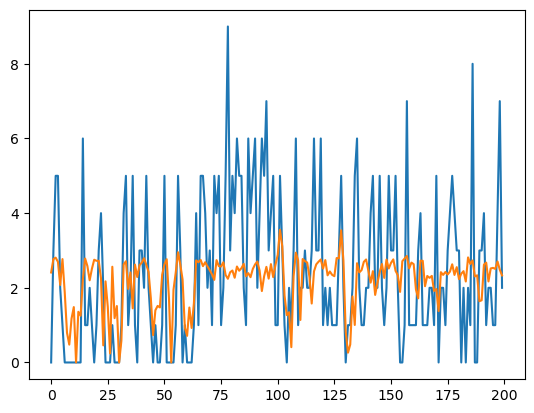

In [5]:
for lenWindow in [10]:
    print(f"================== lenWindow = {lenWindow} =================")
    trainDataAugment = True
    verbose = True

    paramsCA = {}
    paramsCA['lenSource'] = lenWindow
    paramsCA['lenTarget'] = lenWindow
    paramsCA['trainRatio'] = 0.8
    paramsCA['dataAugment'] = trainDataAugment
    paramsCA['smoothFc'] = 1.5
    paramsCA['smoothOrder'] = 3

    #============= Training =============
    trainData, testData = PreparingDatasetCA(thumbUnit, paramsCA, verbose=verbose)
    (sources, _, lastTranmittedContext, _, _, _, _) = trainData
    print(sources.shape, lastTranmittedContext.shape)
    bestWeightsCA, _, _, modleParametersCA = trainModelCA(
    paramsCA['lenSource'], paramsCA['lenTarget'], trainData, testData, verbose=True)

    #============= Evaluatation =============
    trafficModelCA, _ = createModelCA(modleParametersCA)
    trafficModelCA.load_state_dict(bestWeightsCA)
    paramsValid = paramsCA.copy()
    paramsValid['dataAugment'] = False
    trainData, testData = PreparingDatasetCA(thumbUnit, paramsValid, verbose=verbose)
    resultsTrain = evaluateModelCA(trafficModelCA, trainData)
    resultsTest = evaluateModelCA(trafficModelCA, testData)

    #print(f"actual_class_shape: {resultsTrain['classDistribu_actual'].shape}, predicted_class_shape: {resultsTrain['classDistribu_predicted'].shape}")

    plt.plot(resultsTest['trafficTarget_actual'][0:200])
    plt.plot(resultsTest['trafficTarget_predicted'][0:200])
    plt.show()

(8324, 10, 1)


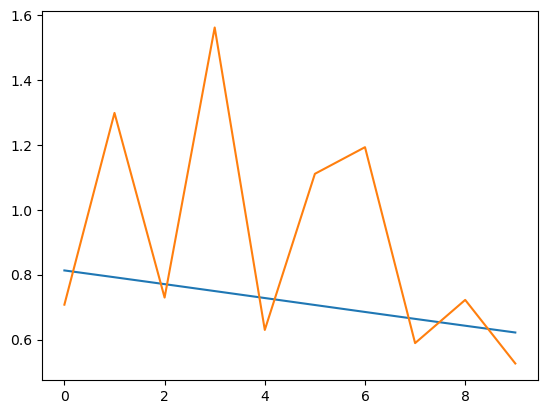

In [6]:
contextActual = resultsTrain['contextTarget_actual']
contextActual = np.concatenate(contextActual, axis=0)
contextPredicted = resultsTrain['contextTarget_predicted']
contextPredicted = np.concatenate(contextPredicted, axis=0)
print(contextPredicted.shape)
plt.plot(contextActual[0,:,0])
plt.plot(contextPredicted[0,:,0])
